In [8]:
import numpy
import torch

from matplotlib import pyplot
from more_itertools.recipes import pairwise
from typing import Collection, NamedTuple, Tuple

In [18]:
class Batch(NamedTuple):
    """Represent a batch of tasks, returned by `generate_sinusoid_batch`."""
    x: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    y: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    amplitude: numpy.ndarray  # (batch_size_meta,)
    phase: numpy.ndarray  # (batch_size_meta,)
    input_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]


def generate_sinusoid_batch(
        batch_size_meta: int,
        batch_size_inner: int,
        amplitude_range: Tuple[float, float]=(0.1, 5.0),
        phase_range: Tuple[float, float]=(0., numpy.pi),
        input_range: Tuple[float, float]=(-5.0, 5.0)) -> Batch:
    """Compute a batch of samples.
    
    We draw `batch_size_meta` tasks, and for each task a batch of `batch_size_inner` points. Each "task"
    represents a regression problem, underlied by a sine wave with some amplitude and phase.
    
    Args:
        batch_size_meta: The number of tasks to draw.
        batch_size_inner: The number of samples for each task.
        amplitude_range: Draw the amplitude of the sine wave for the task uniformly from this range.
        phase_range: Draw the phase of the sine wave for the task uniformly from this range.
        input_range: The range from which the input variable will be drawn uniformly.
    """
    amplitude = numpy.random.uniform(amplitude_range[0], amplitude_range[1], batch_size_meta)
    phase = numpy.random.uniform(phase_range[0], phase_range[1], batch_size_meta)
    
    # All input locations are independent.
    x = numpy.random.uniform(
        input_range[0],
        input_range[1],
        (batch_size_meta, batch_size_inner))
    
    # To compute the outputs, we should broadcast the amplitude & phase over all inner samples.
    y = numpy.expand_dims(amplitude, axis=1) * numpy.sin(x - numpy.expand_dims(phase, axis=1))
    
    return Batch(x, y, amplitude, phase, input_range, amplitude_range)


def plot_task(batch: Batch, index: int):
    """Plot the task with the specified `index` from the given `batch`."""
    # Plot the reference curve
    truth_x = numpy.linspace(batch.input_range[0], batch.input_range[1], 200)
    truth_y = batch.amplitude[index] * numpy.sin(truth_x - batch.phase[index])
    pyplot.plot(truth_x, truth_y, c='r', label='truth')
    
    # Plot the sample points.
    pyplot.plot(batch.x[index], batch.y[index], '^', label='samples')
    
    pyplot.xlim(*batch.input_range)
    max_y = max(batch.amplitude_range)
    pyplot.ylim(-max_y, max_y)
    
    pyplot.legend()

In [21]:
batch = generate_sinusoid_batch(3, 5)

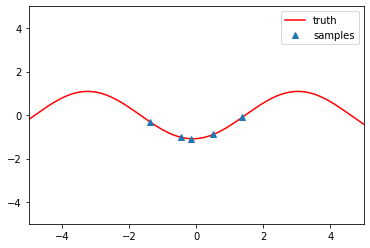

In [22]:
plot_task(batch, 0)

In [12]:
class SinusoidalRegressor(torch.nn.Module):
    """A module suitable for producing  """
    
    def __init__(self, hidden_sizes: Collection[int]=(40, 40)):
        super().__init__()
        dim_in = 1
        dim_out = 1
        all_dims = (dim_in,) + tuple(hidden_sizes) + (dim_out,)
        self.layers = [torch.nn.Linear(dim_1, dim_2) for dim_1, dim_2 in pairwise(all_dims)]
        
        for i, layer in enumerate(self.layers):
            # Register this as a sub-module, so we declare the existence of the necessary parameters
            torch.nn.init.xavier_normal_(layer.weight)
            self.add_module(f'layer_{i}', layer)
            
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        for layer in self.layers:
            x = layer(x)
            x = self.relu(x)
        return x

In [14]:
module = SinusoidalRegressor()